# Association between Fertility & Local Municipal Characteristics in Denmark 

## Imports

In [1]:
#TODO: check if we use all of them (delete/add)
import geopandas as gpd # for geospatial data handling
import pandas as pd 
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import matplotlib as mpl # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
import numpy as np
import scipy
from scipy import stats # for standardizing the data
from sklearn import linear_model # for multiple regression analysis 
import statsmodels.api as sm # for multiple regression analysis 
import esda # for morans I
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights # to plot spatial weigths
from pysal.lib import weights  # for weight matrixes
from sklearn import cluster # for clustering
from sklearn.preprocessing import robust_scale # for scaling 
from matplotlib import colors

# mpl.colors.LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

C:\Users\sutov\AppData\Local\Temp\ipykernel_16932\3156097704.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd # for geospatial data handling


## Load the Data

In [2]:
# Load the data collected from Denmarks Statistics

# total fertility rate (TFR)
data_fer = pd.read_excel('Data/fertility_rates_by_municipality_2021.xlsx')
# education
data_edu = pd.read_excel('Data/Education_women_master_2021.xlsx')
# disposable income
data_inc = pd.read_excel('Data/Disposable_income_2021.xlsx')
# dwelings with CPR
data_dwe = pd.read_excel('Data/Dwellings_with_CPR_2021.xlsx')
# household wealth
data_wea = pd.read_excel('Data/Household_wealth_2021.xlsx')

## Data processing 

### Fertility 
'TRF' - Total Fertility Rate

In [3]:
# print the initial data
data_fer.head()

,Unnamed: 0,2021
0,Copenhagen,1 563.9
1,Frederiksberg,1 787.8
2,Dragør,2 510.9
3,Tårnby,2 056.7
4,Albertslund,1 608.7


In [4]:
# replacing missing values with 0
data_fer = data_fer.replace('..', 0)
# removing spaces and convert numbers to float
data_fer[2021] = data_fer[2021].str.replace(' ', '').astype(float)
# replacing non-finite values with 0 (missing data - later we drop the municipalities (4 only) with TFR = 0)
data_fer[2021] = data_fer[2021].replace([np.inf, -np.inf, np.nan], 0)

In [5]:
# the total fertility rate is per 1000 women, so we change so its easier to understand, also we round the values
data_fer[2021] = round(data_fer[2021] / 1000, 2)

In [6]:
# change the name of the columnns
data_fer.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'TFR'}, inplace = True)

In [7]:
# change name to the same language
data_fer['municipality_nm'] = data_fer['municipality_nm'].replace('Copenhagen', 'København')

In [8]:
# print the final data 
data_fer.head()

,municipality_nm,TFR
0,København,1.56
1,Frederiksberg,1.79
2,Dragør,2.51
3,Tårnby,2.06
4,Albertslund,1.61


### Education 
'master_perc' - the percentage of women in fertile age groups that have master degree or above

In [9]:
# print the initial data
data_edu.head()

,2021,I alt (15-19 år),15-19 år,I alt (20-24 år),20-24 år,I alt (25-29 år),25-29 år,I alt (30-34 år),30-34 år,I alt (35-39 år),35-39 år
0,København,13 267,0,37 149,552,46 656,14 161,35 547,16 102,23 775,9 644
1,Frederiksberg,2 306,0,5 164,74,5 697,2 092,4 442,2 307,3 334,1 594
2,Dragør,429,0,172,1,176,20,309,94,418,134
3,Tårnby,1 189,0,865,5,904,94,1 248,255,1 388,298
4,Albertslund,818,0,952,9,867,97,839,119,785,127


In [10]:
# deal with type
columns_to_process = data_edu.columns[1:]
for column in columns_to_process:
    data_edu[column] = data_edu[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [11]:
# sum all to 'Sum_alt' and sum all age groups to 'Sum_master' and then take the percentage 
# i.e. how many women in perc (age 15-39) have master or above and round it
data_edu['Sum_alt']=data_edu.iloc[:,[1,3,5,7,9]].sum(axis=1)
data_edu['Sum_master']=data_edu.iloc[:,[2,4,6,8,10]].sum(axis=1)
data_edu['master_perc'] = round(data_edu['Sum_master'] * 100 / data_edu['Sum_alt'], 2)

In [12]:
# change the name of the column to be alligned with others
data_edu.rename(columns = {2021:'municipality_nm'}, inplace = True)

In [13]:
# drop unnecessary columns
data_edu = data_edu[['municipality_nm', 'master_perc']]

In [14]:
# print the final data
data_edu.head()

,municipality_nm,master_perc
0,København,25.87
1,Frederiksberg,28.97
2,Dragør,16.56
3,Tårnby,11.66
4,Albertslund,8.26


### Disposable income

'disp_income_avg_k' - average dispodable income for all people (men and women) presented in thousands


In [15]:
# print initial data
data_inc

,Unnamed: 0,2021
0,København,263 154
1,Frederiksberg,319 321
2,Dragør,350 841
3,Tårnby,275 721
4,Albertslund,230 832
...,...,...
93,Morsø,229 968
94,Rebild,270 439
95,Thisted,241 755
96,Vesthimmerlands,244 219


In [16]:
# deal with type
data_inc[2021] = data_inc[2021].str.replace(' ', '').astype(float)

In [17]:
# rename columns 
data_inc.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'disp_income_avg_k'}, inplace = True)

In [18]:
# show in thousands and round the number
data_inc['disp_income_avg_k'] = round(data_inc['disp_income_avg_k']/1000, 2)

In [19]:
# final data 
data_inc.head()

,municipality_nm,disp_income_avg_k
0,København,263.15
1,Frederiksberg,319.32
2,Dragør,350.84
3,Tårnby,275.72
4,Albertslund,230.83


### Dwellings

'dwelling_above_74_perc' - percentage of dwellings with more than 74 square meters 


In [20]:
# print initial data
data_dwe

,2021,- 50 kvm,50-74 kvm,75-99 kvm,100-124 kvm,125-149 kvm,150-174 kvm,175 kvm og derover,Uoplyst
0,København,34 050,120 748,84 785,41 034,18 102,7 823,6 859,405
1,Frederiksberg,4 254,16 871,16 592,8 050,3 939,1 974,2 075,28
2,Dragør,172,694,1 074,1 043,1 372,910,832,7
3,Tårnby,1 187,4 472,5 443,3 139,2 494,1 398,715,7
4,Albertslund,1 899,1 639,3 599,3 027,1 322,648,236,2
...,...,...,...,...,...,...,...,...,...
94,Morsø,254,1 415,1 570,1 643,1 683,1 323,2 060,4
95,Rebild,192,980,1 821,2 106,2 238,2 259,3 430,26
96,Thisted,459,2 298,3 601,3 286,3 307,3 015,4 543,3
97,Vesthimmerlands,454,1 756,2 999,2 904,3 024,2 479,3 731,8


Initial data - dwellings with CPR registered persons (occupied dwellings) - count of dwellings per group (groups: 50 kvm, 50-74 kvm, 75-99 kvm, 100-124 kvm, 125-149 kvm, 150-174 kvm, 175 kvm og derover, Uoplyst).


In [21]:
# deal with type (to float)
columns_to_process = data_dwe.columns[1:]
for column in columns_to_process:
    data_dwe[column] = data_dwe[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [22]:
# Calculate the percentage of missing data and sort in the descending order
data_dwe['missing_perc'] =  data_dwe['Uoplyst'] / (data_dwe.iloc[:,1:].sum(axis=1)) * 100
data_dwe.sort_values('missing_perc', ascending=False)

,2021,- 50 kvm,50-74 kvm,75-99 kvm,100-124 kvm,125-149 kvm,150-174 kvm,175 kvm og derover,Uoplyst,missing_perc
59,Fanø,29.0,201.0,309.0,327.0,318.0,203.0,347.0,13,0.744133
50,Langeland,83.0,841.0,1477.0,1253.0,1094.0,746.0,1116.0,19,0.286619
24,Helsingør,1824.0,6079.0,8098.0,5069.0,3896.0,2268.0,2328.0,70,0.236231
41,Odsherred,689.0,2961.0,3462.0,2945.0,2619.0,1610.0,2109.0,35,0.213025
95,Rebild,192.0,980.0,1821.0,2106.0,2238.0,2259.0,3430.0,26,0.199203
...,...,...,...,...,...,...,...,...,...,...
13,Ishøj,823.0,1700.0,2275.0,2889.0,1136.0,422.0,409.0,1,0.010357
76,Silkeborg,1527.0,5541.0,9061.0,7217.0,6471.0,5495.0,7570.0,4,0.009327
8,Gladsaxe,3507.0,8384.0,10822.0,4620.0,2130.0,1373.0,1194.0,2,0.006244
92,Læsø,13.0,134.0,163.0,192.0,181.0,143.0,173.0,0,0.000000


In [23]:
# since the maximum share of  missing values is below 0.8 perc, followed by less than 0.3 perc, we reemove the 
# missing data (Uoplyst)
data_dwe.drop(['Uoplyst', 'missing_perc'], inplace = True, axis = 1)

In [24]:
# sum all 'I alt' and sum all age groups and then take the percentage i.e. how many women in perc (age 15-39) have master or above
data_dwe['Sum_total'] = data_dwe.iloc[:,1:].sum(axis=1)
data_dwe['Sum_more_than_74'] = data_dwe.iloc[:,3:7].sum(axis=1)
data_dwe['dwelling_above_74_perc'] = round(data_dwe['Sum_more_than_74'] * 100 / data_dwe['Sum_total'], 2)

In [25]:
# rename columns 
data_dwe.rename(columns = {2021:'municipality_nm'}, inplace = True)

In [26]:
# drop unnecessary columns
data_dwe = data_dwe[['municipality_nm', 'dwelling_above_74_perc']]

In [27]:
#  final data
data_dwe

,municipality_nm,dwelling_above_74_perc
0,København,48.42
1,Frederiksberg,56.84
2,Dragør,72.15
3,Tårnby,66.18
4,Albertslund,69.49
...,...,...
94,Morsø,62.52
95,Rebild,64.67
96,Thisted,64.41
97,Vesthimmerlands,65.75


### Wealth

'household_wealth_avg_k' - average wealth (DKK) of the household for the the real estate, owners

In [28]:
# print initial data
data_wea

,Unnamed: 0,2021
0,København,3 629 877
1,Frederiksberg,4 487 733
2,Dragør,5 105 646
3,Tårnby,3 408 593
4,Albertslund,3 088 083
...,...,...
93,Morsø,1 903 637
94,Rebild,2 711 788
95,Thisted,2 119 288
96,Vesthimmerlands,2 261 126


In [29]:
# deal with type
data_wea[2021] = data_wea[2021].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [30]:
# rename columns
data_wea.rename(columns = {'Unnamed: 0':'municipality_nm', 2021:'household_wealth_avg_k'}, inplace = True)

In [31]:
# show in thousands and round the number
data_wea['household_wealth_avg_k'] = round(data_wea['household_wealth_avg_k']/1000, 2)

### Final dataset

In [32]:
# load geometries for Danish municipaliities
geometries = gpd.read_file('Data/municipalities_dk.gpkg')

In [33]:
# check if the data have the same number of municipalities (there should be 98)
print(geometries.shape)
print(data_fer.shape)
print(data_edu.shape)
print(data_dwe.shape)
print(data_fer.shape)
print(data_wea.shape)

(99, 5)
(99, 2)
(99, 2)
(99, 2)
(99, 2)
(98, 2)


In [34]:
# Merge the data frames based on the 'municipality_nm' column using left join
merged_df = pd.merge(data_fer, data_edu, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_inc, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_dwe, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_wea, on='municipality_nm', how='left')

In [35]:
# Find rows with null values
null_rows = merged_df[merged_df.isnull().any(axis=1)]

print(null_rows)

   municipality_nm  TFR  master_perc  disp_income_avg_k  \
29     Christiansø  0.0         12.5                NaN   

    dwelling_above_74_perc  household_wealth_avg_k  
29                     NaN                     NaN  


In [36]:
# Drop Christiansø as it is not a municipality 
merged_df = merged_df.drop(merged_df[merged_df['municipality_nm'] == 'Christiansø'].index)

In [37]:
# print info about the the data set
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 98
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   municipality_nm         98 non-null     object 
 1   TFR                     98 non-null     float64
 2   master_perc             98 non-null     float64
 3   disp_income_avg_k       98 non-null     float64
 4   dwelling_above_74_perc  98 non-null     float64
 5   household_wealth_avg_k  98 non-null     float64
dtypes: float64(5), object(1)
memory usage: 5.4+ KB


In [38]:
# rename columns
geometries = geometries.rename(columns={'navn': 'municipality_nm'}) #added

In [39]:
# merge dataset with geometries
data = merged_df.merge(geometries, on='municipality_nm')

In [40]:
# check if dataset have 98 mucinipalities
data.shape

(98, 10)

In [41]:
data.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,kommunekode,region,municipal_id,geometry
0,København,1.56,25.87,263.15,48.42,3629.88,0101,NaN,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
1,Frederiksberg,1.79,28.97,319.32,56.84,4487.73,0147,NaN,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
2,Dragør,2.51,16.56,350.84,72.15,5105.65,0155,NaN,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
3,Tårnby,2.06,11.66,275.72,66.18,3408.59,0185,NaN,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
4,Albertslund,1.61,8.26,230.83,69.49,3088.08,0165,NaN,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


In [42]:
# municipalities where TFR = 0 has actually missing data, so lets see which ones they are
data[data['TFR'] == 0]

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,kommunekode,region,municipal_id,geometry
55,Ærø,0.0,6.89,224.59,62.82,1733.19,0492,NaN,492,"MULTIPOLYGON (((577300.890 6092306.180, 577293..."
58,Fanø,0.0,8.73,273.56,66.72,2575.21,0563,NaN,563,"MULTIPOLYGON (((467916.440 6135175.900, 467908..."
74,Samsø,0.0,11.76,244.54,61.76,2551.29,0741,NaN,741,"MULTIPOLYGON (((603519.380 6196685.170, 603520..."
91,Læsø,0.0,5.69,234.39,67.97,1740.73,0825,NaN,825,"MULTIPOLYGON (((615696.720 6346079.540, 615701..."


In [43]:
# drop those whith TFR = 0, since there is no data about fertility in the 4 small islands and they become outliers. 
data = data[data['TFR'] != 0]

In [44]:
# drop other unnecessary data
data.drop(['region', 'kommunekode'], axis=1, inplace=True)

In [45]:
# check shape again
data.shape

(94, 8)

In [46]:
# save the DataFrame to a xlsx file
data.to_excel('data.xlsx', index=False)

In [47]:
# create a final Geo dataset (add geometry)
gdf = gpd.GeoDataFrame(data, geometry=data.geometry, crs = 'EPSG:25832') #added

In [48]:
# Print final geo dataset
gdf.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry
0,København,1.56,25.87,263.15,48.42,3629.88,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
1,Frederiksberg,1.79,28.97,319.32,56.84,4487.73,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
2,Dragør,2.51,16.56,350.84,72.15,5105.65,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
3,Tårnby,2.06,11.66,275.72,66.18,3408.59,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
4,Albertslund,1.61,8.26,230.83,69.49,3088.08,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


In [49]:
gdf = gdf.set_index("municipal_id", drop=False) # we use the id columns as index for easy access to our spatial weights 

In [50]:
gdf.index

Int64Index([101, 147, 155, 185, 165, 151, 153, 157, 159, 161, 163, 167, 169,
            183, 173, 175, 187, 201, 240, 210, 250, 190, 270, 260, 217, 219,
            223, 230, 400, 253, 259, 350, 265, 269, 320, 376, 316, 326, 360,
            370, 306, 329, 330, 340, 336, 390, 420, 430, 440, 482, 410, 480,
            450, 461, 479, 530, 561, 607, 510, 621, 540, 550, 573, 575, 630,
            580, 710, 766, 615, 707, 727, 730, 740, 746, 706, 751, 657, 661,
            756, 665, 760, 779, 671, 791, 810, 813, 860, 849, 846, 773, 840,
            787, 820, 851],
           dtype='int64', name='municipal_id')

In [51]:
# # save the GeoDataFrame to a GeoJSON file
# gdf.to_file('Data/gdf.geojson', driver='GeoJSON')

### EDA

In [52]:
# descriptive statistics
data.describe()

,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,1.928085,9.291489,268.902447,66.099255,2991.963511,453.957447
std,0.223160,5.349446,49.549007,4.709047,1066.650133,236.488283
min,1.550000,2.810000,216.230000,48.420000,1901.420000,101.000000
25%,1.772500,5.280000,242.442500,64.435000,2264.360000,232.500000
50%,1.880000,7.315000,257.540000,66.010000,2669.415000,415.000000
75%,2.060000,11.712500,273.312500,68.815000,3476.357500,669.500000
max,2.510000,28.970000,529.710000,79.550000,7895.550000,860.000000


In [53]:
characteristics = ['TFR','master_perc', 'disp_income_avg_k','dwelling_above_74_perc', 'household_wealth_avg_k']

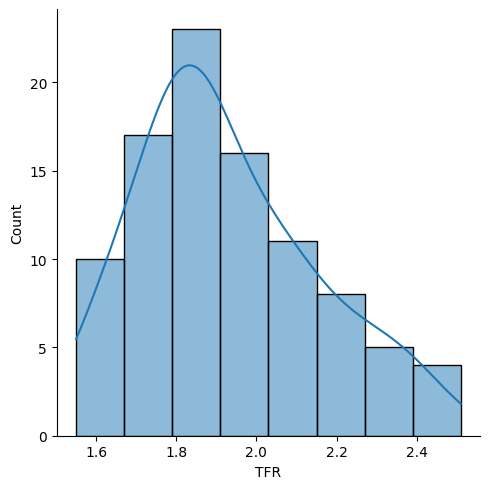

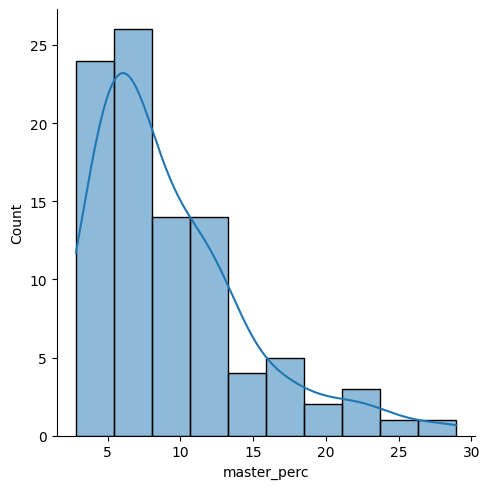

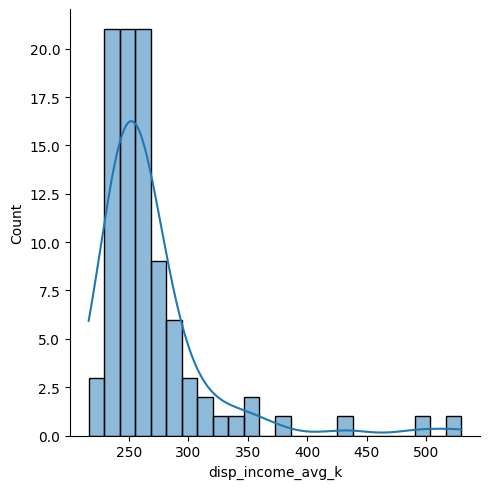

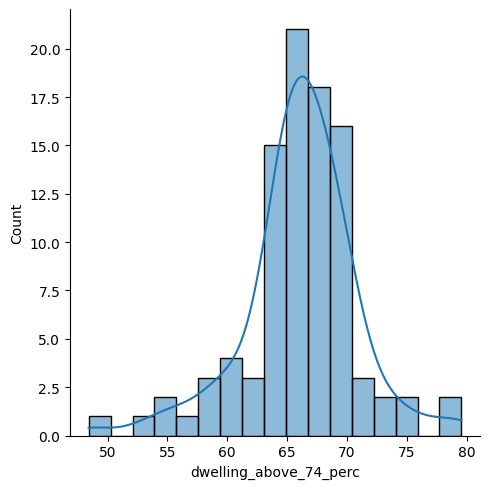

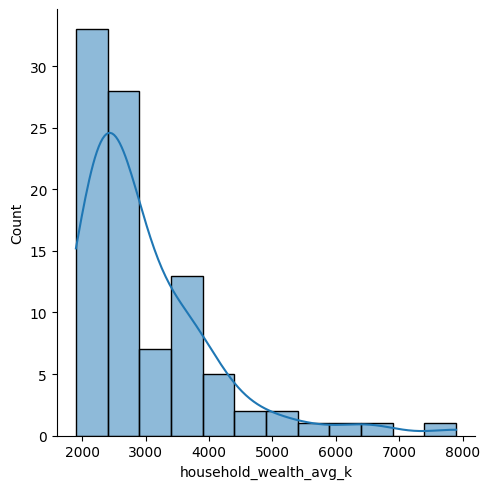

In [54]:
# Distributions of characteristics ()
for feature in characteristics:
    sns.displot(data, x = feature, kde = True)

### Multiple regression analysis

In [55]:
gdf.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry
municipal_id,,,,,,,,
101,København,1.56,25.87,263.15,48.42,3629.88,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
147,Frederiksberg,1.79,28.97,319.32,56.84,4487.73,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
155,Dragør,2.51,16.56,350.84,72.15,5105.65,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
185,Tårnby,2.06,11.66,275.72,66.18,3408.59,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
165,Albertslund,1.61,8.26,230.83,69.49,3088.08,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


1. Check the distribution of the data (if Gaussian -> linear regression; if not gaussian -> generalized linear regression; if not linear -> GAM)

https://analyticsindiamag.com/guide-to-generalized-additive-modelgam-to-improve-simple-linear-regression/

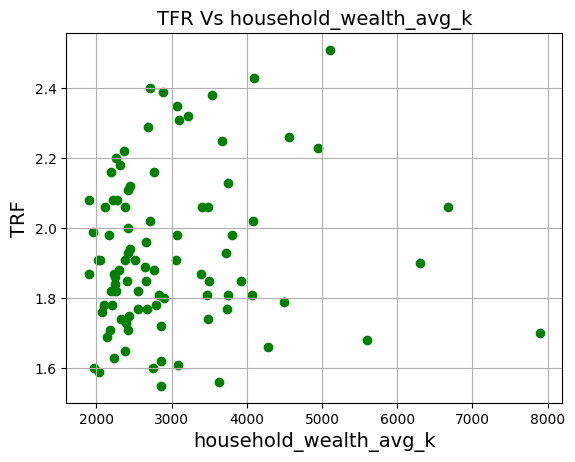

In [56]:
# TODO: figure out witch regression to use (multiple variables, cant check if gaussian)
# plot relationship between fertility rate and other variables 
plt.scatter(data['household_wealth_avg_k'], data['TFR'], color='green')
plt.title('TFR Vs household_wealth_avg_k', fontsize=14)
plt.xlabel('household_wealth_avg_k', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

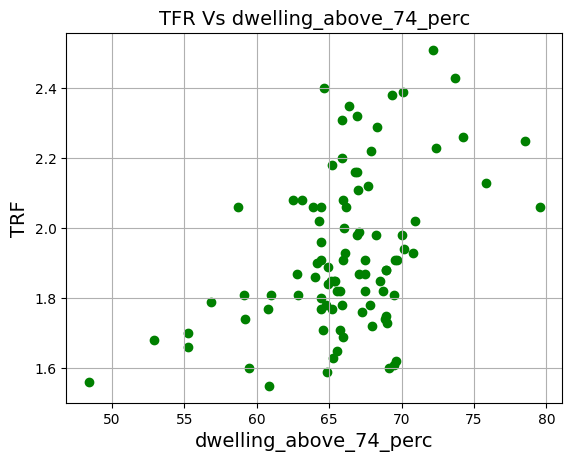

In [57]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['dwelling_above_74_perc'], data['TFR'], color='green')
plt.title('TFR Vs dwelling_above_74_perc', fontsize=14)
plt.xlabel('dwelling_above_74_perc', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

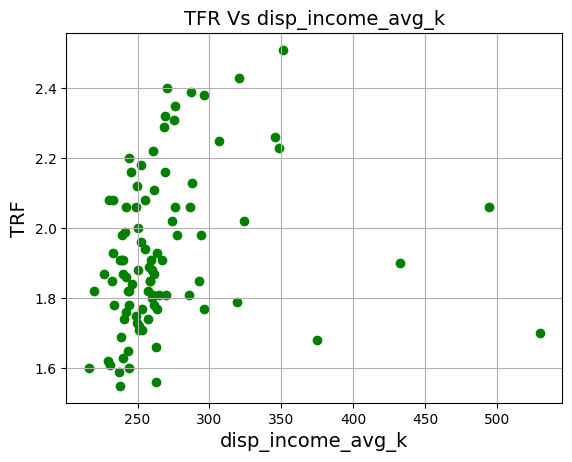

In [58]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['disp_income_avg_k'], data['TFR'], color='green')
plt.title('TFR Vs disp_income_avg_k', fontsize=14)
plt.xlabel('disp_income_avg_k', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

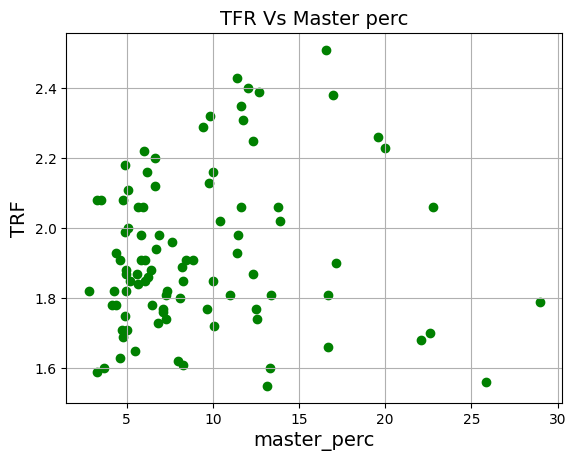

In [59]:
# plot relationship between fertility rate and other variables 
plt.scatter(data['master_perc'], data['TFR'], color='green')
plt.title('TFR Vs Master perc', fontsize=14)
plt.xlabel('master_perc', fontsize=14)
plt.ylabel('TRF', fontsize=14)
plt.grid(True)
plt.show()

### Multiple linear regression analysis

In [60]:
characteristics

['TFR',
 'master_perc',
 'disp_income_avg_k',
 'dwelling_above_74_perc',
 'household_wealth_avg_k']

In [61]:
# Z-Score using scipy
data['TFR_st'] = stats.zscore(data['TFR'])
data['master_perc_st'] = stats.zscore(data['master_perc'])
data['disp_income_avg_k_st'] = stats.zscore(data['disp_income_avg_k'])
data['dwelling_above_74_perc_st'] = stats.zscore(data['dwelling_above_74_perc'])
data['household_wealth_avg_k_st'] = stats.zscore(data['household_wealth_avg_k'])

In [62]:
x = data[['master_perc_st', 'disp_income_avg_k_st', 'dwelling_above_74_perc_st', 'household_wealth_avg_k_st']]
y = data['TFR_st'] 

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 -3.2415138758933394e-15
Coefficients: 
 [ 0.48509585  0.82657783  0.53945595 -0.93987587]


In [63]:
# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 TFR_st   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     12.84
Date:                Wed, 24 May 2023   Prob (F-statistic):           2.70e-08
Time:                        14:35:24   Log-Likelihood:                -111.96
No. Observations:                  94   AIC:                             233.9
Df Residuals:                      89   BIC:                             246.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Correlation

In [64]:
data[['TFR', 'master_perc_st', 'disp_income_avg_k_st', 'dwelling_above_74_perc_st', 'household_wealth_avg_k_st']].corr()

,TFR,master_perc_st,disp_income_avg_k_st,dwelling_above_74_perc_st,household_wealth_avg_k_st
TFR,1.000000,0.104829,0.218995,0.440265,0.109989
master_perc_st,0.104829,1.000000,0.723615,-0.355978,0.836659
disp_income_avg_k_st,0.218995,0.723615,1.000000,-0.165318,0.925041
dwelling_above_74_perc_st,0.440265,-0.355978,-0.165318,1.000000,-0.223584
household_wealth_avg_k_st,0.109989,0.836659,0.925041,-0.223584,1.000000


## ESDA

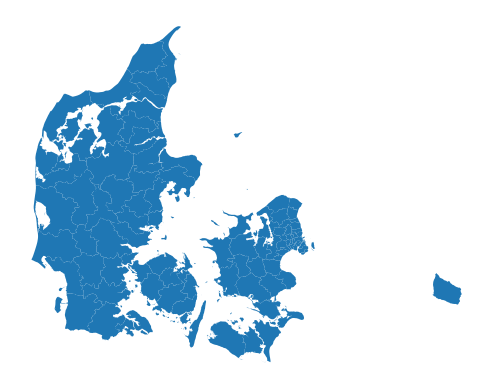

In [65]:
ax = gdf.plot(linewidth=0.3);
ax.set_axis_off()

In [66]:
characteristics_nm = ['TFR (Total Fertility Rate)', 'Master degree above (%)', 'Disposable income (thousands, dkk)', 'Dwelling above 74 sq. m. (%)', 'Household wealth (thousands, dkk)']

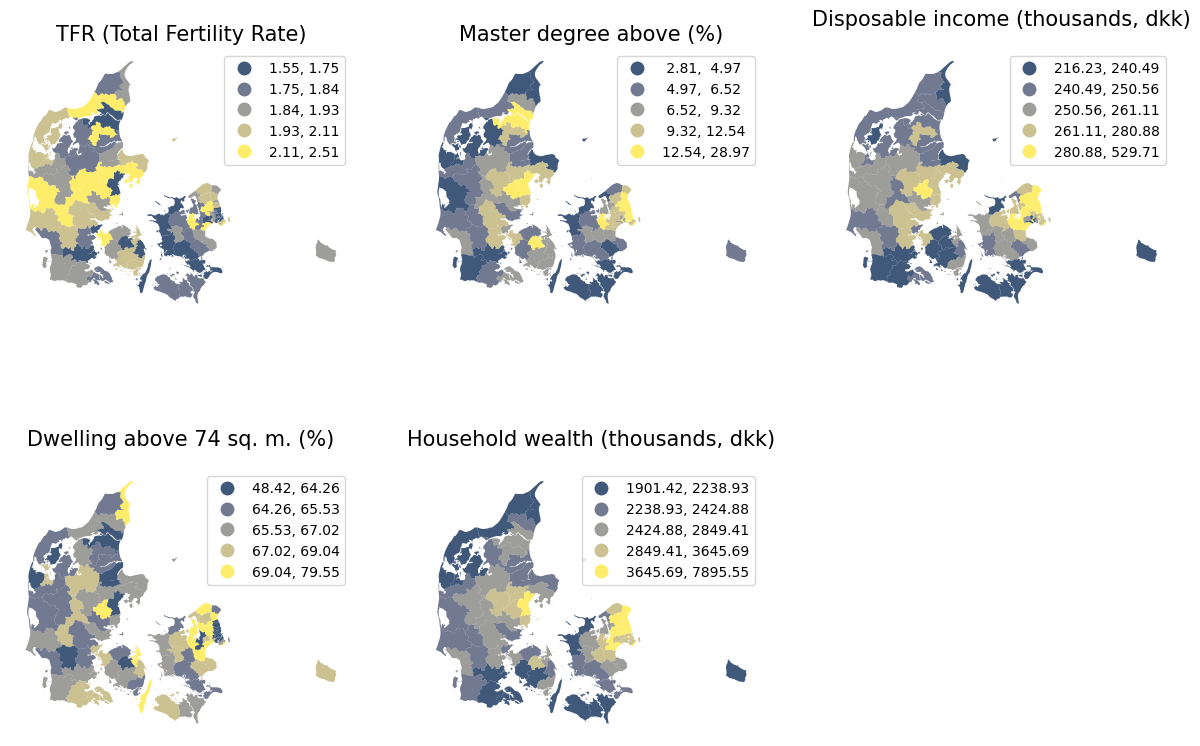

In [67]:

f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()


for i, col in enumerate(characteristics):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col, 
        ax=ax, 
        scheme='Quantiles',
        linewidth=0.2, 
        cmap='cividis',
        alpha=0.75,
        legend=True,  # Add legend
        legend_kwds={'fontsize':10}
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title 
    ax.set_title(characteristics_nm[i], fontsize = 15)
    
#plt.savefig('data_vis.png')

plt.show()

### Spatial Weigths

In [68]:
w_knn = weights.KNN.from_dataframe(gdf, k=8)
w_dist40kmC = weights.DistanceBand.from_dataframe(gdf, 40000, binary=False)
w_dist50kmC = weights.DistanceBand.from_dataframe(gdf, 50000, binary=False)
w_dist60kmC = weights.DistanceBand.from_dataframe(gdf, 60000, binary=False)

c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\scipy\sparse\_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 400.
  warnings.warn(message)


In [69]:
# the average count of neighbors in a municipality
print('40km:', w_dist40kmC.mean_neighbors)
print('50km:', w_dist50kmC.mean_neighbors)
print('60km:', w_dist60kmC.mean_neighbors)

40km: 13.319148936170214
50km: 17.25531914893617
60km: 20.617021276595743


c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


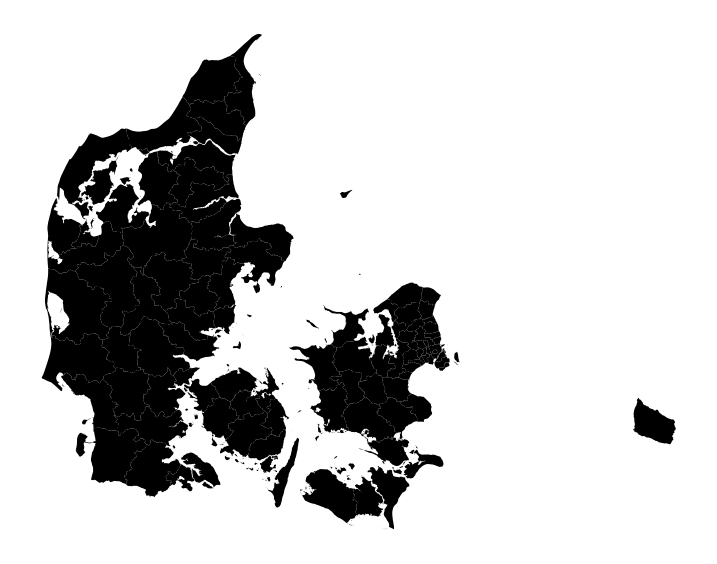

In [70]:
# knn plot to see if there are any islands
ax = gdf.plot(color='k', linewidth=0.2, figsize=(9, 9))
gdf.loc[w_knn.islands, :].plot(color='red', linewidth=0.2, ax=ax)
ax.set_axis_off()

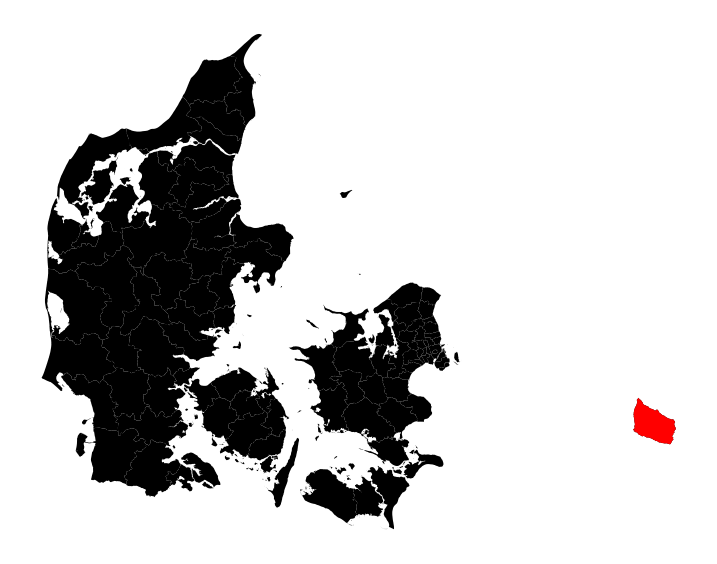

In [71]:
# distance based plot to see if there are any islands
# Note: the plot is the same for 40km, 50km, 60km 
ax = gdf.plot(color='k', linewidth=0.2, figsize=(9, 9))
gdf.loc[w_dist60kmC.islands, :].plot(color='red', linewidth=0.2, ax=ax)
ax.set_axis_off()

In [72]:
# Since Bronholm in an island and we are not connecting it, we will drop it
gdf = gdf.drop(w_dist60kmC.islands)

In [73]:
# Since we cant decide based on visual inspection(40/50/60), we calculate Minimun threshold to help us decide.

# Extract centroids
cents = gdf.centroid
# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values

min_thr = weights.min_threshold_distance(pts)
min_thr


33902.55967045878

In [74]:
# according to the the minimum threshold, we need to use at least ~33903m to have fully connected map

# after dropping an Island we need to recalculate the weigths
w = weights.DistanceBand.from_dataframe(gdf, 50000, binary=False)

c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\scipy\sparse\_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [75]:
# The we standardize weights, so each row sums up to 1
w.transform = 'R'

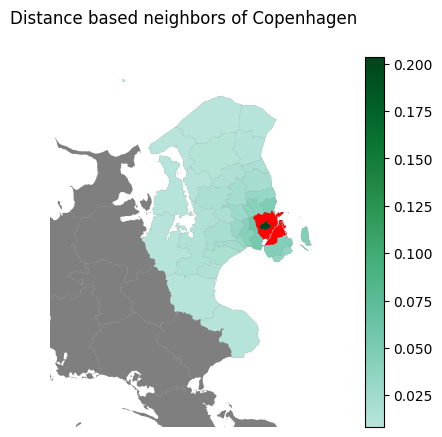

In [76]:
mun_id = 101 # the id of municipality which we want to show as an example

orig_cmap = plt.cm.BuGn
colors = orig_cmap(np.linspace(0.3, 1.0, 10))
cmap_cust = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

# Setup figure
f, ax = plt.subplots(1)
# Plot base layer of polygons
gdf.plot(ax=ax, facecolor='k', linewidth=1, alpha=0.5)
# Select focal polygon
focus = gdf.loc[[mun_id], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=1, ax=ax)
# Plot neighbors
neis = gdf.loc[list(w[mun_id].keys()), :]
neis_w = list(w[mun_id].values())
neis['neis_w'] = neis_w
neis.plot(column='neis_w', ax=ax, linewidth=0.5, cmap=cmap_cust, legend=True)
# Title
f.suptitle("Distance based neighbors of Copenhagen")
# Style and display on screen
ax.set_xlim(640000, 750000)
ax.set_ylim(6100000, 6240000)
ax.set_axis_off()
plt.show()


c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


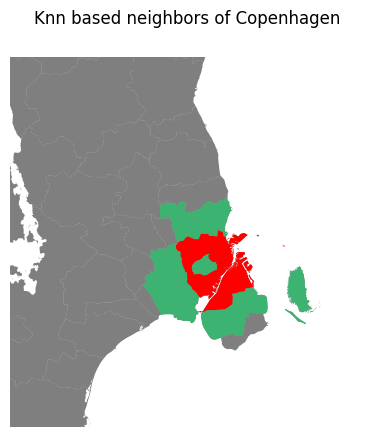

In [77]:
mun_id = 101

# Setup figure
f, ax = plt.subplots(1)
# Plot base layer of polygons
gdf.plot(ax=ax, facecolor='k', linewidth=1, alpha=0.5)
# Select focal polygon
focus = gdf.loc[[mun_id], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=1, ax=ax)
# Plot neighbors
neis = gdf.loc[list(w_knn[mun_id].keys()), :]
neis_w = list(w_knn[mun_id].values())
neis['neis_w'] = neis_w
neis.plot(column='neis_w', ax=ax, linewidth=0.5, color='mediumseagreen')
# Title
f.suptitle("Knn based neighbors of Copenhagen")
# Style and display on screen
ax.set_xlim(690000, 750000)
ax.set_ylim(6150000, 6210000)
ax.set_axis_off()
plt.show()


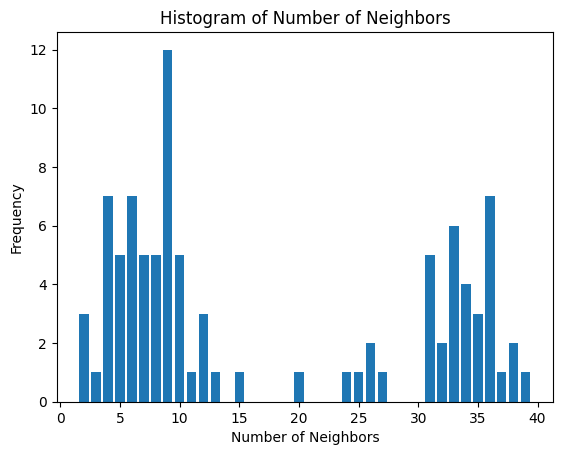

In [78]:
# Get the number of neighbors for each municipality
neighbor_counts = w.neighbors
# Count the occurrences of each number of neighbors
counts = {}
for neighbors in neighbor_counts.values():
    count = len(neighbors)
    counts[count] = counts.get(count, 0) + 1

# Extract the counts and corresponding number of neighbors
num_neighbors = list(counts.keys())
frequency = list(counts.values())

# Create a histogram
plt.bar(num_neighbors, frequency)

# Customize the plot as desired (e.g., add a title, x-label, y-label, etc.)
plt.title('Histogram of Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Frequency')

# Show the plot
plt.show()

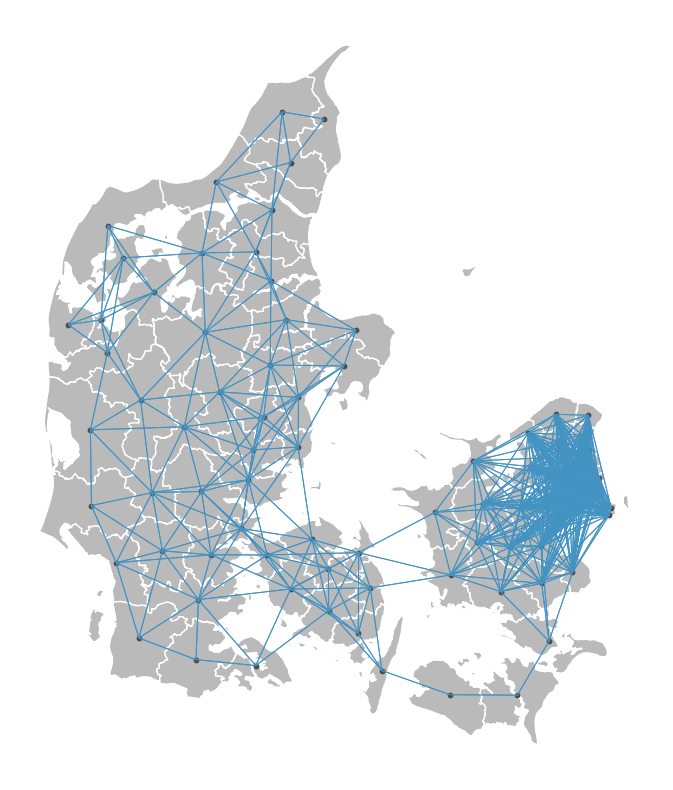

In [79]:
# from the plot above we can see that while some of the municipalities have a lot of neighbours, others have very little
# lets inspect that visually:
plot_spatial_weights(w, gdf, indexed_on="municipal_id");

In [80]:
# we can see that bigger municipalities are the ones taht have less neighbours as expected, which makes sense

## Spatial Lag

In [81]:
# EXAMPLE for one variable only

# calculate spatial lag for TFR
gdf['w_TFR'] = weights.lag_spatial(w, gdf['TFR']) # we pass the weights object and the column with values to base the spatial lag on
gdf[['municipality_nm', 'TFR', 'w_TFR']].head()

,municipality_nm,TFR,w_TFR
municipal_id,,,
101,København,1.56,1.890705
147,Frederiksberg,1.79,1.840712
155,Dragør,2.51,1.897847
185,Tårnby,2.06,1.960156
165,Albertslund,1.61,1.902290


Interpretation:
Copenhagen, where total fertility rate is 1.56%, is surrounded by neighbouring municipalies which, on average, have total fertility rate of
1.9%.

In [82]:
# For all characteristics 

for variable in characteristics:
    # calculate spatial lag for TFR
    gdf[f'w_{variable}'] = weights.lag_spatial(w, gdf[variable]) # we pass the weights object and the column with values to base the spatial lag on
    # standardize the variable
    gdf[f'{variable}_std'] = (
        gdf[variable] - gdf[variable].mean()
    ) / gdf[variable].std()
    # spatial lag
    gdf[f'w_{variable}_std'] = weights.lag_spatial(w, gdf[f'{variable}_std'])

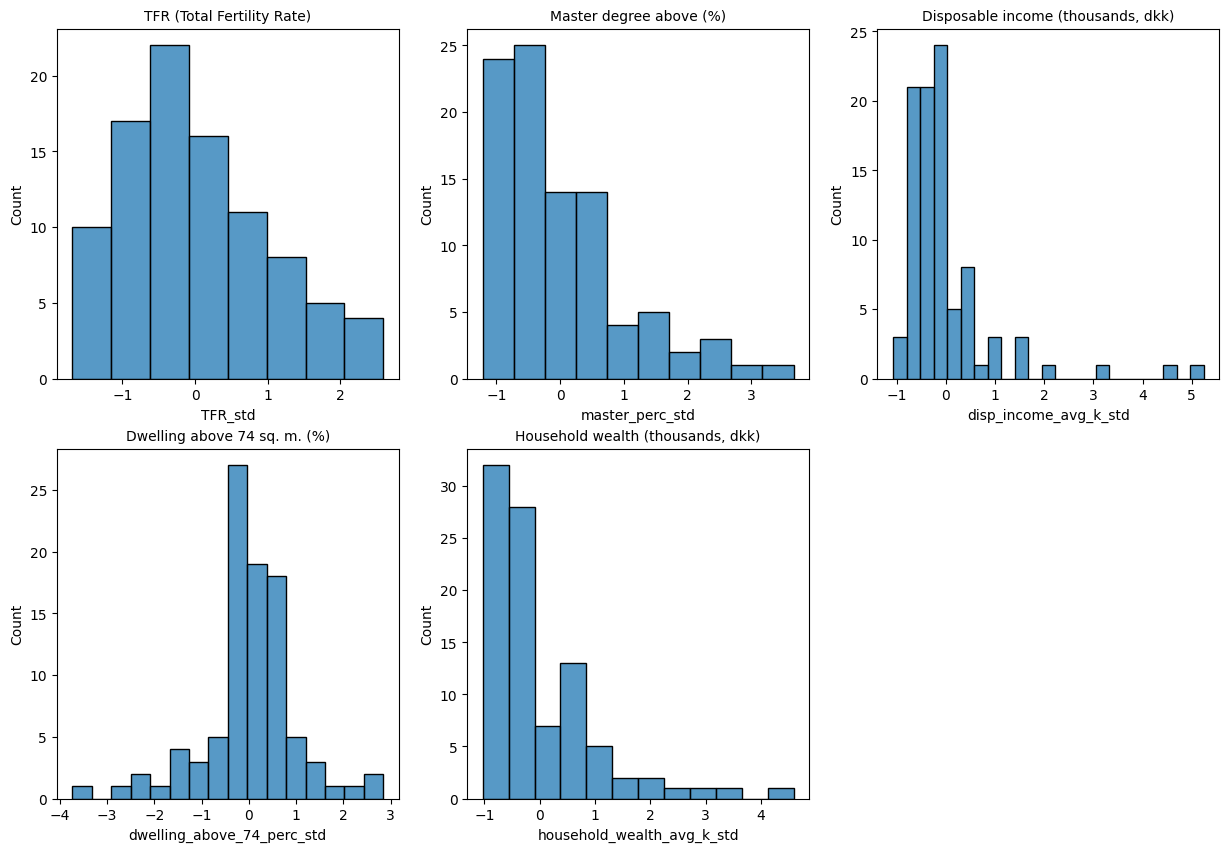

In [83]:
# PLot spatial lags
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()


for i, variable in enumerate(characteristics):
    # select the axis where the map will go
    ax = axs[i]
    # plot
    sns.histplot(gdf[f'{variable}_std'], ax=ax);

    # # Remove axis clutter
    # ax.set_axis_off()
    # Set the axis title 
    ax.set_title(characteristics_nm[i], fontsize = 10)

plt.show()

### Moran's I
Assesses the similarity or dissimilarity of attribute values between neighboring locations. 

In [84]:
# Calculate Moran's I for each variable
mi_results_save = [esda.Moran(gdf[variable], w) for variable in characteristics]
# Structure results as a list of tuples
mi_results = [(variable, res.I, res.p_sim) for variable,res in zip(characteristics, mi_results_save)]
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Variable', "Moran's I", 'P-value']
).set_index('Variable')
table

,Moran's I,P-value
Variable,,
TFR,0.059952,0.092
master_perc,0.481404,0.001
disp_income_avg_k,0.333148,0.001
dwelling_above_74_perc,0.083671,0.032
household_wealth_avg_k,0.533961,0.001


Global Morans I  for TFR (Total Fertility Rate)


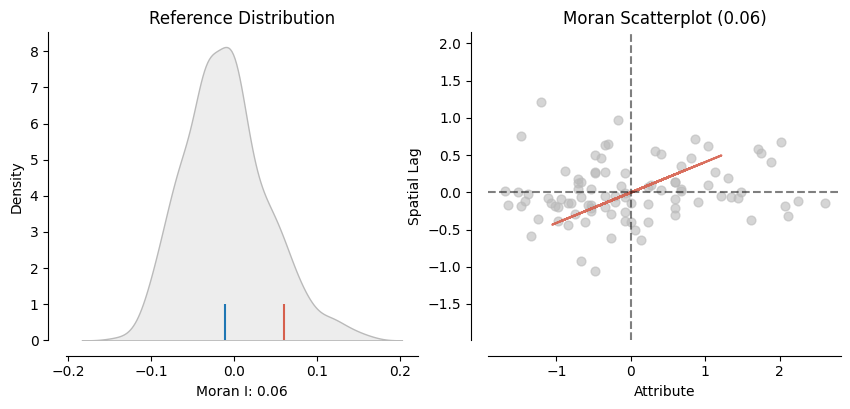

Global Morans I  for Master degree above (%)


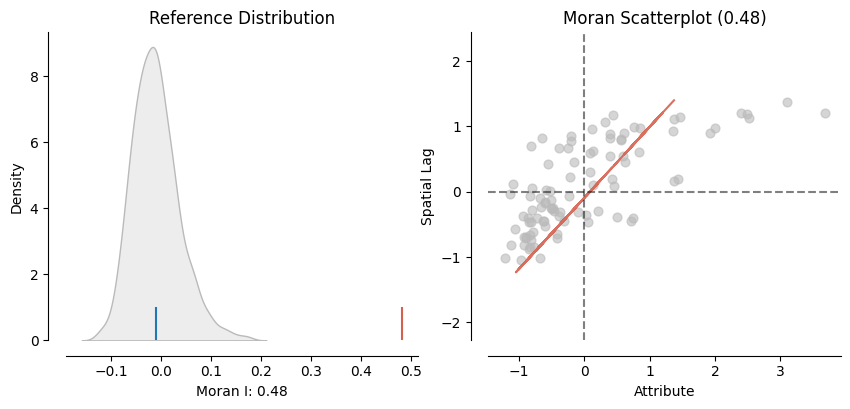

Global Morans I  for Disposable income (thousands, dkk)


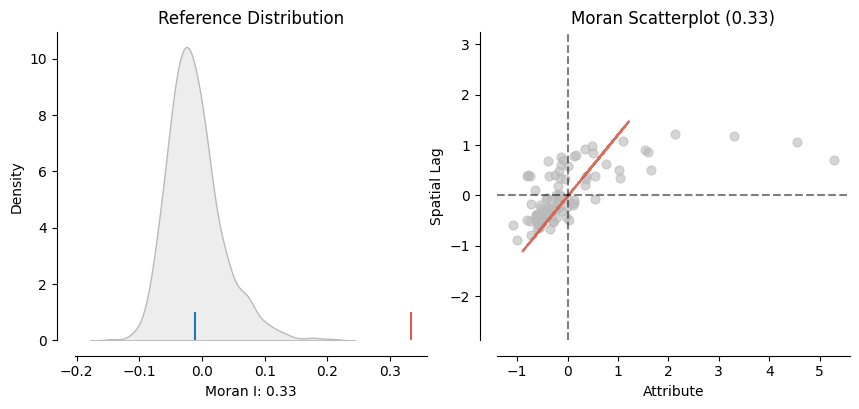

Global Morans I  for Dwelling above 74 sq. m. (%)


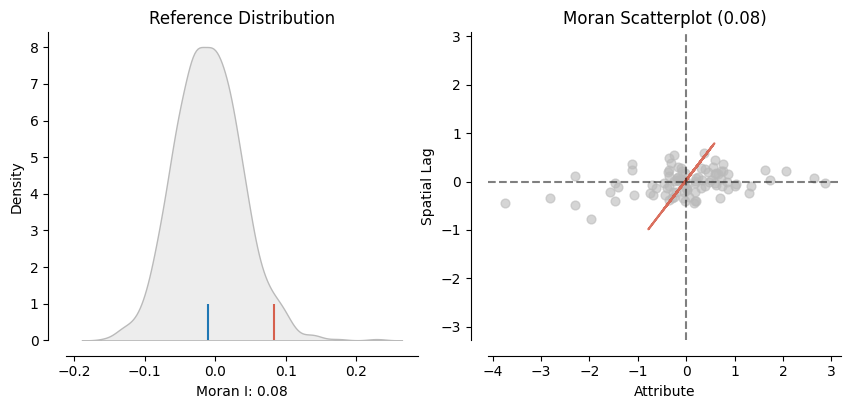

Global Morans I  for Household wealth (thousands, dkk)


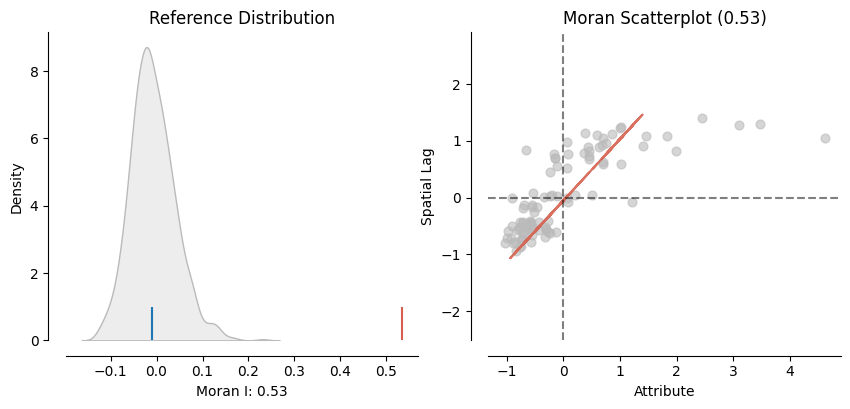

In [85]:
for i, variable in enumerate(characteristics):
    print(f'Global Morans I  for {characteristics_nm[i]:}')
    plot_moran(mi_results_save[i])
    plt.show()

In the context of spatial autocorrelation analysis, the reference distribution in the plot_moran function typically refers to the null distribution of Moran's I statistic. Moran's I is a measure of spatial autocorrelation that quantifies the degree of similarity or dissimilarity between the attribute values of neighboring spatial units.

The reference distribution is obtained through Monte Carlo simulation, where random permutations of the attribute values are generated under the assumption of spatial randomness. The Moran's I statistic is calculated for each permutation, resulting in a distribution of Moran's I values. This distribution represents the expected values of Moran's I under the null hypothesis of no spatial autocorrelation.

In the plot_moran function, the reference distribution is plotted along with the observed Moran's I statistic as a histogram. The observed Moran's I value is usually shown as a vertical line on the plot. By comparing the observed Moran's I value to the reference distribution, you can assess whether there is a significant departure from spatial randomness.

If the observed Moran's I value falls within the central portion of the reference distribution (i.e., the histogram), it suggests that the spatial pattern in the data is consistent with spatial randomness. On the other hand, if the observed Moran's I value falls in the tails of the reference distribution, it indicates significant spatial autocorrelation. Positive spatial autocorrelation suggests clustering of similar attribute values, while negative spatial autocorrelation suggests dispersion or segregation of dissimilar attribute values.

In summary, the reference distribution in the plot_moran function serves as a reference point for evaluating the observed spatial autocorrelation and determining whether it is statistically significant.

In [86]:
# TODO: have code for the comment above
gdf.sort_values(by = 'TFR', ascending=False)[:10]

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry,w_TFR,TFR_std,...,w_master_perc_std,w_disp_income_avg_k,disp_income_avg_k_std,w_disp_income_avg_k_std,w_dwelling_above_74_perc,dwelling_above_74_perc_std,w_dwelling_above_74_perc_std,w_household_wealth_avg_k,household_wealth_avg_k_std,w_household_wealth_avg_k_std
municipal_id,,,,,,,,,,,,,,,,,,,,,
155,Dragør,2.51,16.56,350.84,72.15,5105.65,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555...",1.897847,2.591721,...,0.929631,293.924436,1.642144,0.495099,64.924023,1.281727,-0.245202,3878.203235,1.971224,0.820121
269,Solrød,2.43,11.40,320.67,73.71,4091.14,269,"MULTIPOLYGON (((701667.890 6162425.540, 701665...",1.903413,2.235036,...,0.541764,286.765787,1.034115,0.350828,67.243068,1.611372,0.244838,3640.680756,1.019814,0.597372
840,Rebild,2.40,12.04,270.44,64.67,2711.79,840,"MULTIPOLYGON (((545466.530 6314400.070, 545401...",1.857761,2.101279,...,-0.391214,245.733240,0.021807,-0.476120,64.434742,-0.298880,-0.348593,2367.161070,-0.273744,-0.596938
350,Lejre,2.39,12.66,287.11,70.10,2887.75,350,"MULTIPOLYGON (((684542.650 6171881.690, 684547...",1.887340,2.056693,...,0.446842,288.192109,0.357765,0.379573,66.829011,0.848539,0.157343,3592.306073,-0.108729,0.552006
746,Skanderborg,2.38,16.99,295.90,69.32,3533.73,746,"MULTIPOLYGON (((560146.040 6230414.140, 560138...",2.080961,2.012107,...,0.197409,265.778403,0.534914,-0.072140,64.476348,0.683717,-0.339801,3053.981640,0.497073,0.047164
710,Favrskov,2.35,11.63,276.04,66.34,3067.43,710,"MULTIPOLYGON (((571885.540 6243871.140, 571887...",2.019567,1.878350,...,0.198862,262.326629,0.134666,-0.141706,64.627987,0.054009,-0.307758,2989.877061,0.059776,-0.012954
727,Odder,2.32,9.81,269.32,66.92,3219.10,727,"MULTIPOLYGON (((565703.600 6189190.160, 565712...",2.045627,1.744593,...,0.300981,266.776603,-0.000765,-0.052023,65.057556,0.176570,-0.216985,3047.788487,0.202012,0.041356
740,Silkeborg,2.31,11.73,275.25,65.86,3094.26,740,"MULTIPOLYGON (((527982.820 6246588.270, 527977...",2.057709,1.700008,...,0.086130,264.487066,0.118745,-0.098165,65.784077,-0.047420,-0.063464,2919.787059,0.084937,-0.078684
410,Middelfart,2.29,9.44,268.28,68.31,2681.22,410,"MULTIPOLYGON (((552673.640 6156841.540, 552661...",1.844403,1.610836,...,-0.353270,248.505852,-0.021725,-0.420242,65.998208,0.470292,-0.018215,2408.822688,-0.302413,-0.557868


TFR: it implies that neighboring areas tend to have slightly similar values, but the pattern is not very strong or pronounced. 
If we look at the 10 municipalities  with the highest fertility rate, we see that most of them are oplandskommuner, and then hovedstads kommuner:

Dragrør  - Hovedstadskommuner

Solrød  - Hovedstadkommune 

Rebild - Oplandskommune 

Lejre - Oplandskommune 

Skanderborg - Oplandskommune 

Favrskov - Oplandskommune 

Odder - Oplandskommune 

Silkeborg - Provinsbykommune 

Middelfart - Oplandskommune 

Allerød - hovedstadkommune 

In [87]:
# LOWEST
# TODO: have code for the comment above
gdf.sort_values(by = 'TFR', ascending=True)[:10]

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry,w_TFR,TFR_std,...,w_master_perc_std,w_disp_income_avg_k,disp_income_avg_k_std,w_disp_income_avg_k_std,w_dwelling_above_74_perc,dwelling_above_74_perc_std,w_dwelling_above_74_perc_std,w_household_wealth_avg_k,household_wealth_avg_k_std,w_household_wealth_avg_k_std
municipal_id,,,,,,,,,,,,,,,,,,,,,
461,Odense,1.55,13.13,238.12,60.84,2863.08,461,"MULTIPOLYGON (((587550.860 6140916.610, 587554...",1.932213,-1.688502,...,-0.450932,246.627496,-0.629553,-0.458097,67.199302,-1.108202,0.235589,2362.058866,-0.131864,-0.601723
101,København,1.56,25.87,263.15,48.42,3629.88,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090...",1.890705,-1.643916,...,1.365365,307.322131,-0.125112,0.765109,63.951125,-3.732686,-0.450787,4174.499633,0.587243,1.097989
306,Odsherred,1.59,3.26,237.04,64.87,2041.40,306,"MULTIPOLYGON (((641996.700 6209602.820, 641991...",1.928286,-1.510159,...,-0.039539,275.037023,-0.651318,0.114453,68.632027,-0.256618,0.538340,3005.417623,-0.902438,0.001620
482,Langeland,1.60,3.69,216.23,69.14,1966.40,482,"MULTIPOLYGON (((602234.800 6078762.990, 602242...",1.889097,-1.465574,...,-0.562796,240.090081,-1.070712,-0.589849,66.774479,0.645680,0.145820,2387.897924,-0.972773,-0.577491
851,Aalborg,1.60,13.30,244.34,59.46,2750.40,851,"MULTIPOLYGON (((557400.690 6323373.320, 557399...",2.096529,-1.465574,...,-0.398776,250.628504,-0.504198,-0.377463,65.557602,-1.399811,-0.111320,2351.400897,-0.237536,-0.611718
165,Albertslund,1.61,8.26,230.83,69.49,3088.08,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352...",1.902290,-1.420988,...,0.771571,289.121387,-0.776471,0.398301,66.287587,0.719639,0.042934,3816.026436,0.079141,0.761812
183,Ishøj,1.62,7.98,229.37,69.63,2852.90,183,"MULTIPOLYGON (((710750.900 6170636.460, 710710...",1.924847,-1.376402,...,0.665759,288.415474,-0.805895,0.384075,67.765772,0.749223,0.355291,3749.963010,-0.141411,0.699857
390,Vordingborg,1.63,4.60,239.82,65.30,2239.07,390,"MULTIPOLYGON (((710006.200 6101733.040, 710010...",1.796932,-1.331817,...,-0.702232,251.036079,-0.595292,-0.369249,67.498723,-0.165754,0.298860,2534.648323,-0.717063,-0.439868
330,Slagelse,1.65,5.49,243.58,65.56,2379.68,330,"MULTIPOLYGON (((654675.250 6154223.210, 654636...",1.847495,-1.242645,...,-0.392174,257.593477,-0.519515,-0.237095,67.380437,-0.110813,0.273865,2572.542058,-0.585198,-0.404332


Odense - Storbykommune 

København  - Hovedstadskommuner

Odsherred - Landkommune 

Langeland  - Landkommune

Aalborg - Storbykommune 

Albertslund - Hovedstadskommune 

Ishøj - Hovedstadskommune 

Vordingborg - Landkommune 

Slagelse -Provinsbykommune 

Aarhus - Storbykommune 

3 storbykommuner and all of them are on the top 10 list for lowest TFR

## Local spatial autocorrelation

### Classification of observations from the Moran Plot

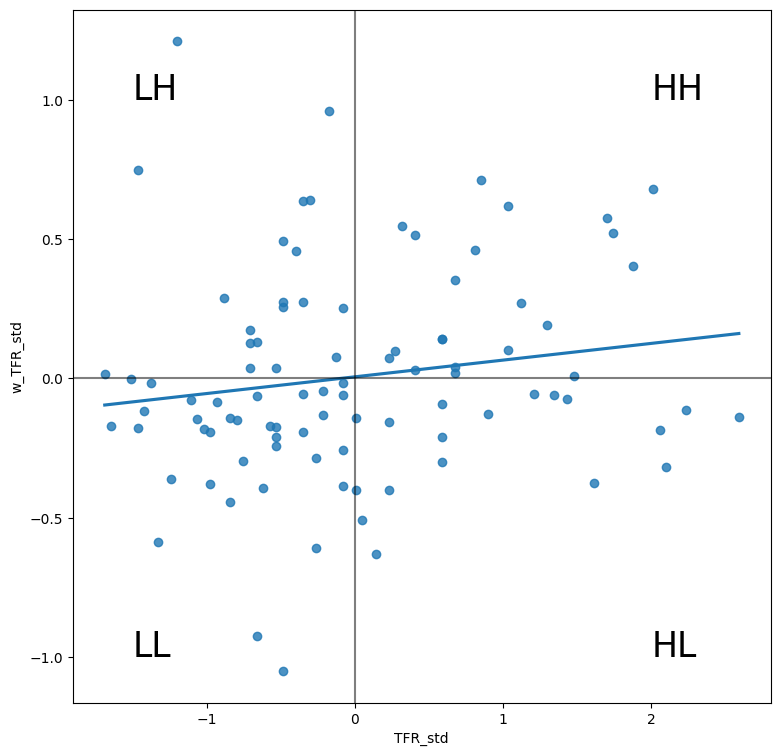

In [95]:
# Lets see where each of the 4 groups (HH, LL, HL, LH) fall into the Moran Plot:
    
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='TFR_std', y='w_TFR_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(2, 1, "HH", fontsize=25)
plt.text(2, -1, "HL", fontsize=25)
plt.text(-1.5, 1, "LH", fontsize=25)
plt.text(-1.5, -1, "LL", fontsize=25)
# Display
plt.show()

### LISA

In [121]:
lisa_TFR = esda.Moran_Local(gdf['TFR'], w)
lisa_master_perc = esda.Moran_Local(gdf['master_perc'], w)
lisa_disp_income_avg_k = esda.Moran_Local(gdf['disp_income_avg_k'], w)
lisa_dwelling_above_74_perc = esda.Moran_Local(gdf['dwelling_above_74_perc'], w)
lisa_household_wealth_avg_k = esda.Moran_Local(gdf['household_wealth_avg_k'], w)

In [122]:
for variable in characteristics:
    # Break observations into significant or not
    lisa_value = globals()[f'lisa_{variable}'] 
    gdf[f'{variable}_significant'] = lisa_value.p_sim < 0.1
    # Store the quadrant they belong to
    gdf[f'{variable}_quadrant'] = lisa_value.q

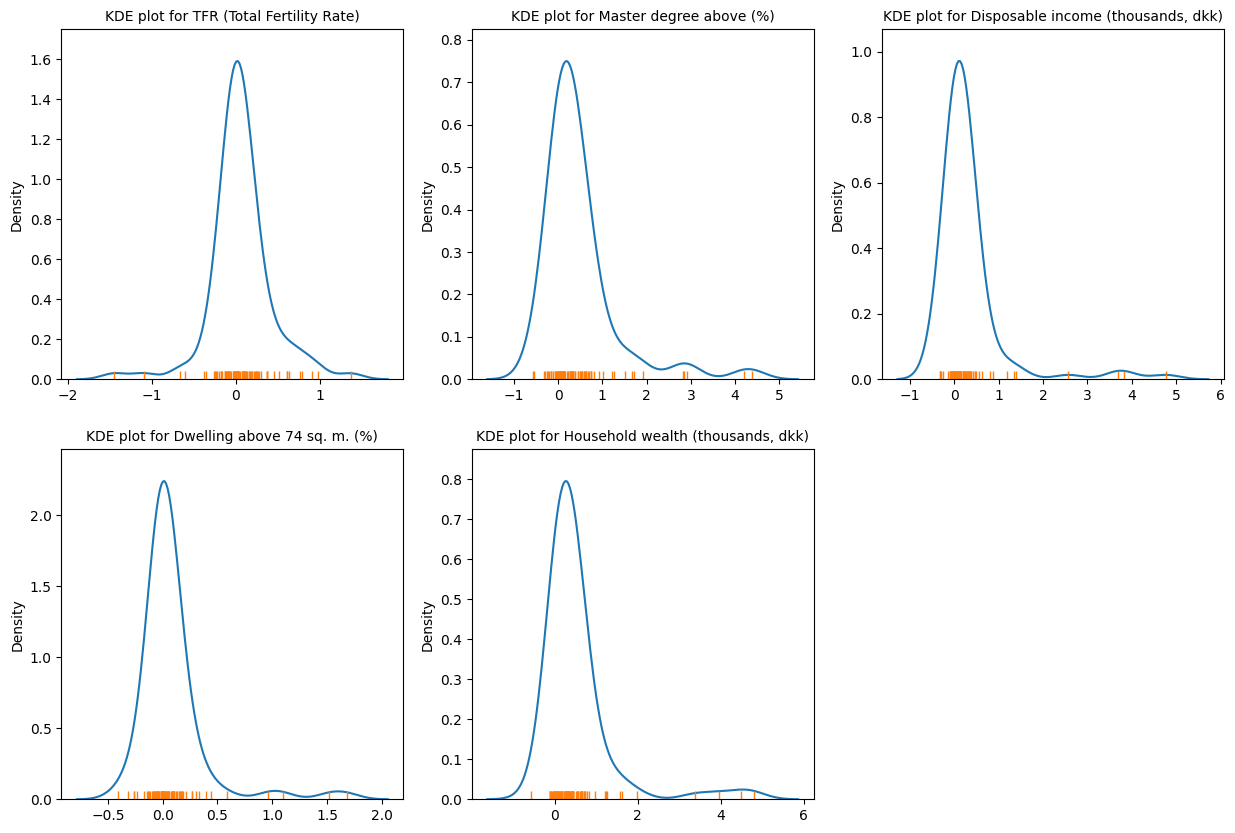

In [123]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()

for i, variable in enumerate(characteristics):
    # Draw KDE line
    # Get the corresponding lisa value
    lisa_value = globals()[f'lisa_{variable}'] 
    ax = sns.kdeplot(lisa_value.Is, ax=axs[i])
    # Add one small bar (rug) for each observation
    # along horizontal axis
    sns.rugplot(lisa_value.Is, ax=axs[i])

    # # Remove axis clutter
    # ax.set_axis_off()
    # Set the axis title 
    ax.set_title(f'KDE plot for {characteristics_nm[i]}', fontsize = 10)

plt.show()

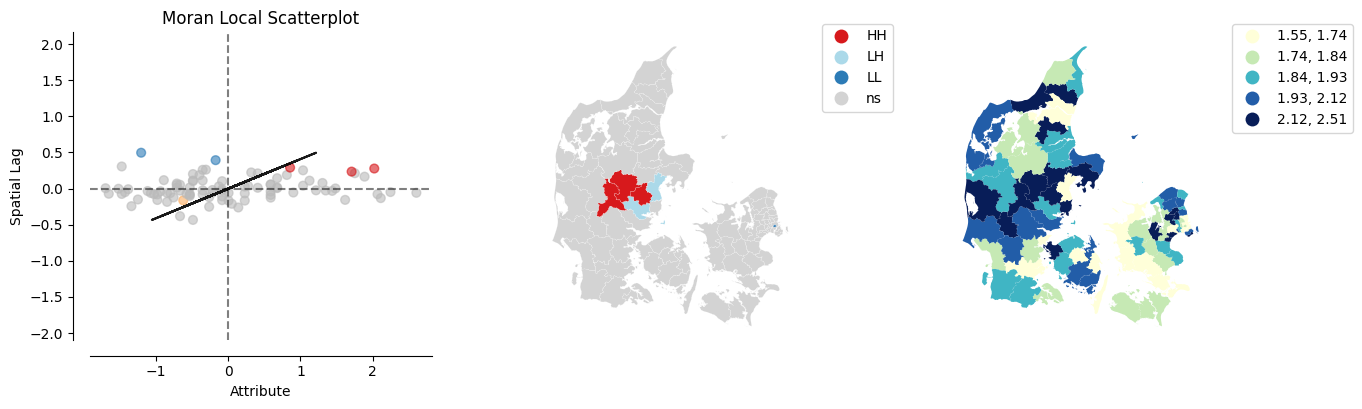

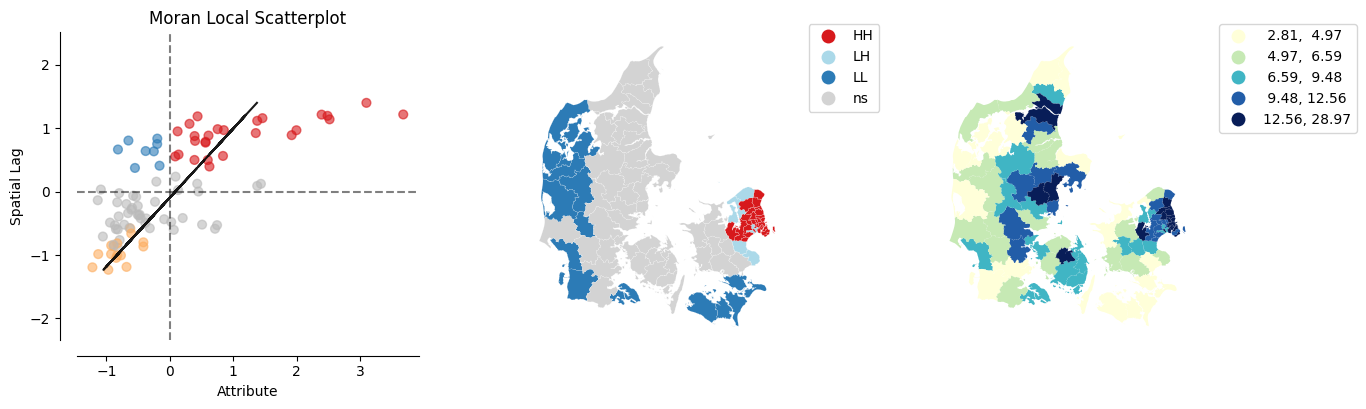

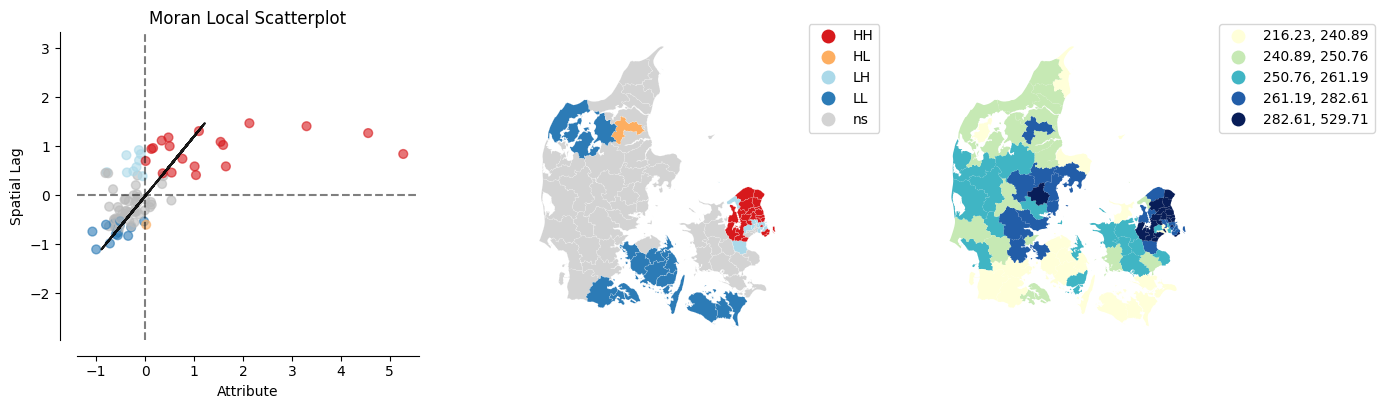

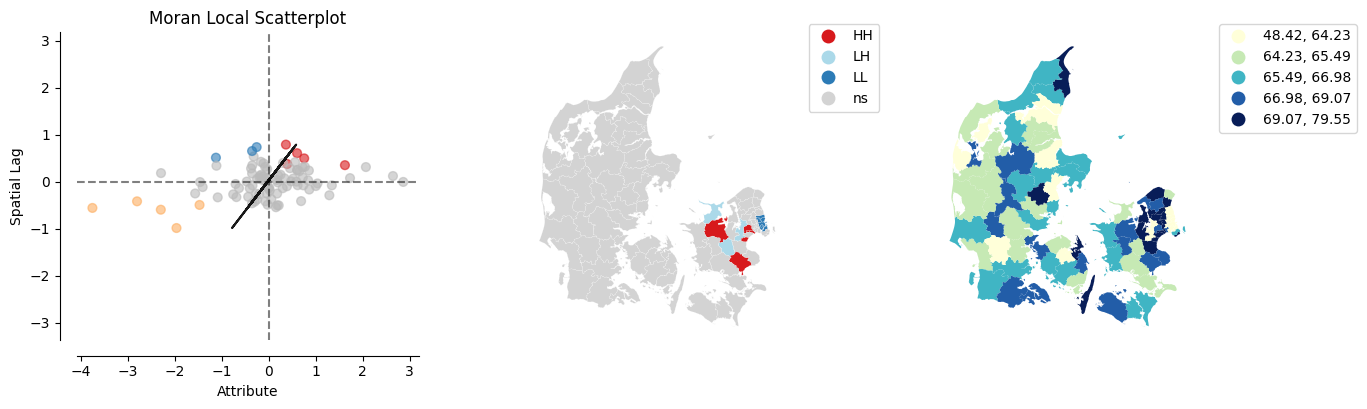

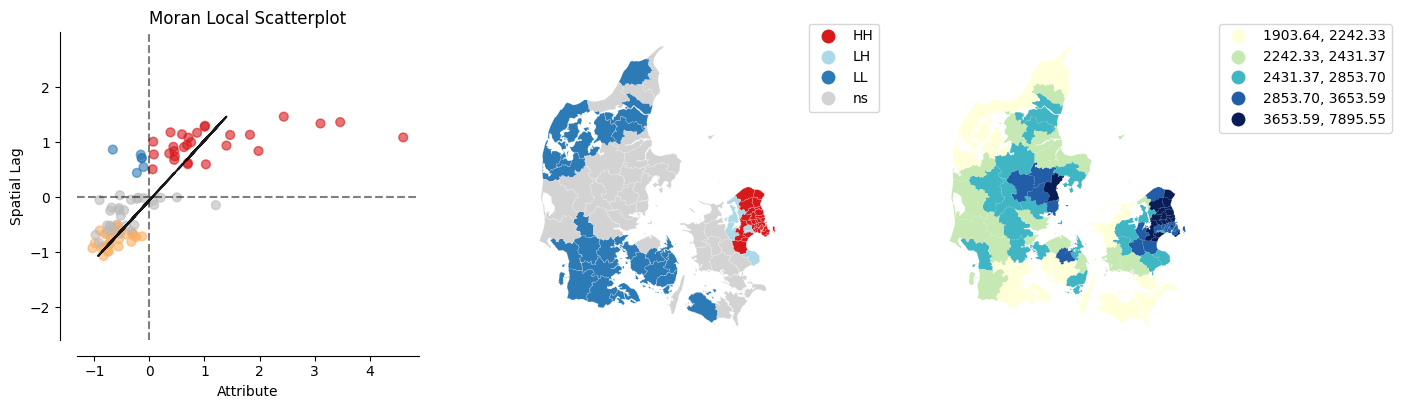

In [124]:
for variable in characteristics:
    lisa_value = globals()[f'lisa_{variable}'] 
    plot_local_autocorrelation(lisa_value, gdf, variable);


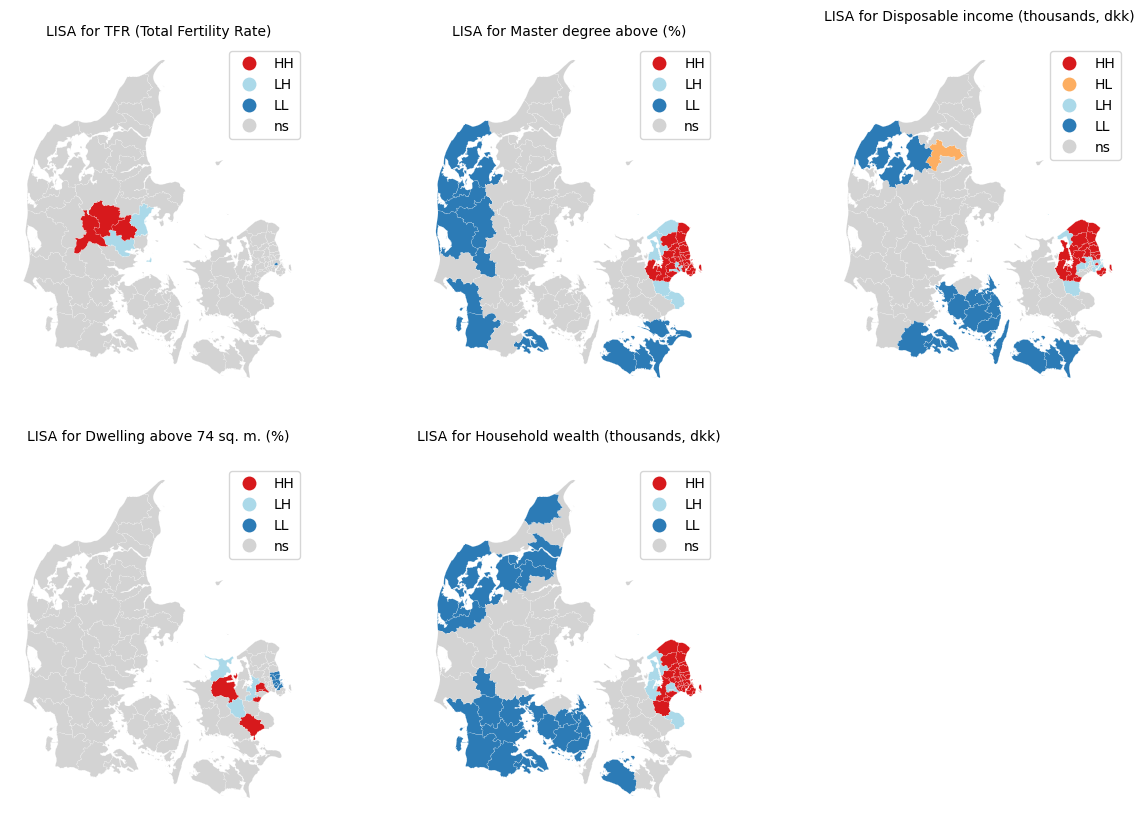

In [125]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()

for i, variable in enumerate(characteristics):
    lisa_value = globals()[f'lisa_{variable}'] 
    fig = lisa_cluster(lisa_value, gdf, ax=axs[i])
    # # Remove axis clutter
    # ax.set_axis_off()
    # Set the axis title 
    axs[i].set_title(f'LISA for {characteristics_nm[i]}', fontsize = 10)

plt.show()


## Clustering

### K-means

Using elbow method to find the optimal k

In [89]:
# TODO: Anna: why this way of scaling?
# scale data
elbow_df = gdf[['TFR', 'master_perc', 'disp_income_avg_k', 'dwelling_above_74_perc', 'household_wealth_avg_k']]
scaled_elbow_df = robust_scale(elbow_df)

In [90]:
# TODO: Anna: add a vertical red line to the plot (4 clusters)
#Define a range of values for k
k_values = range(1, 11)
inertias = []

# Perform k-means clustering for each value of k
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(scaled_elbow_df)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
#plt.savefig('ElbowMethod.png')
plt.show()

KeyboardInterrupt: 

In [ ]:
# TODO: Anna: everywhere add comments
kmeans4 = cluster.KMeans(n_clusters=4, random_state=12345)

In [ ]:
# TODO: Anna: change cols -> characteristics, use characteristics_nm for better labels
# scale data
for c in characteristics:
    gdf[c+'_scaled'] = robust_scale(gdf[c])

In [ ]:
cluster_cols_scaled = [c+'_scaled' for c in cols]

In [ ]:
# Run the clustering algorithm
k4cls = kmeans4.fit(gdf[cluster_cols_scaled])

In [ ]:
k4cls.labels_

array([2, 2, 0, 1, 1, 1, 1, 3, 2, 2, 2, 2, 1, 1, 3, 2, 0, 0, 0, 0, 1, 0,
       1, 1, 2, 0, 3, 3, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2])

In [ ]:
# append to original data
# TODO: Anna: change names to better understand
gdf['k4cls'] = k4cls.labels_

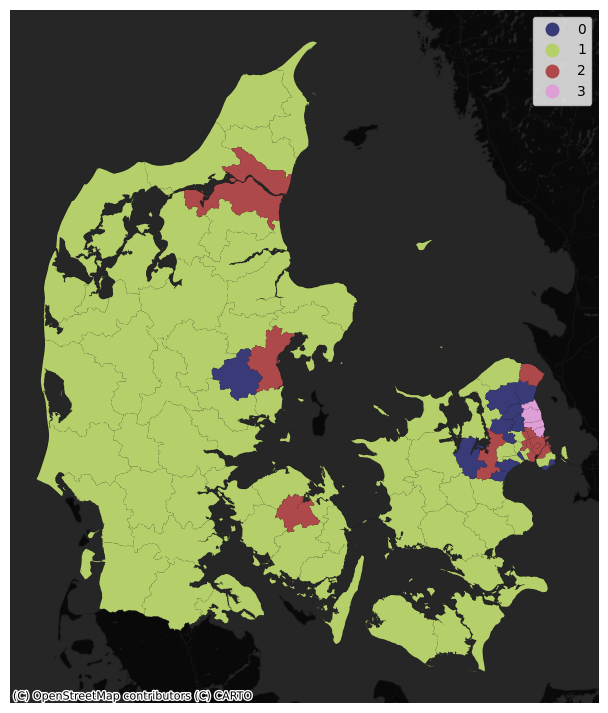

In [ ]:
# Plot clusters 
f, ax = plt.subplots(1, figsize=(9, 9))

gdf.plot(
    column='k4cls', 
    categorical=True, 
    legend=True, 
    linewidth=0, 
    ax=ax, 
    cmap='tab20b'
)
# Remove axis
ax.set_axis_off()
# Add title
#plt.title('Need to find a title')

# Add basemap
cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels # can change this to something (white if thats better)
)
plt.savefig('Kmeanscluster.png')
# Display the map
plt.show()

In [ ]:
# Count of municipalities is in each group 
# TODO: Anna: some chunks are irrelevant to print, group them
k4sizes = gdf.groupby('k4cls').size()
k4sizes

k4cls
0    11
1    66
2    12
3     4
dtype: int64

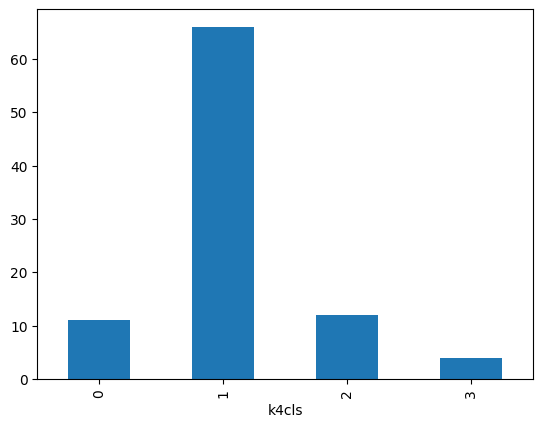

In [ ]:
# TODO: Anna: add titles and x, y labels to plots
k4sizes.plot.bar();

In [ ]:
# TODO: Anna: print the municipalities for each cluster and TFR

In [ ]:
# Calculate the mean by group
k4means = gdf.groupby('k4cls')[cols].mean()

k4means.T

k4cls,0,1,2,3
TFR,2.240000,1.917727,1.735000,1.8350
master_perc,14.400000,6.642879,15.530833,21.1475
disp_income_avg_k,313.378182,250.375455,270.630000,457.6975
dwelling_above_74_perc,73.177273,66.634848,59.329167,57.7625
household_wealth_avg_k,3990.347273,2502.310000,3652.367500,6617.1150


Draw the distributions of cluster members’ data:

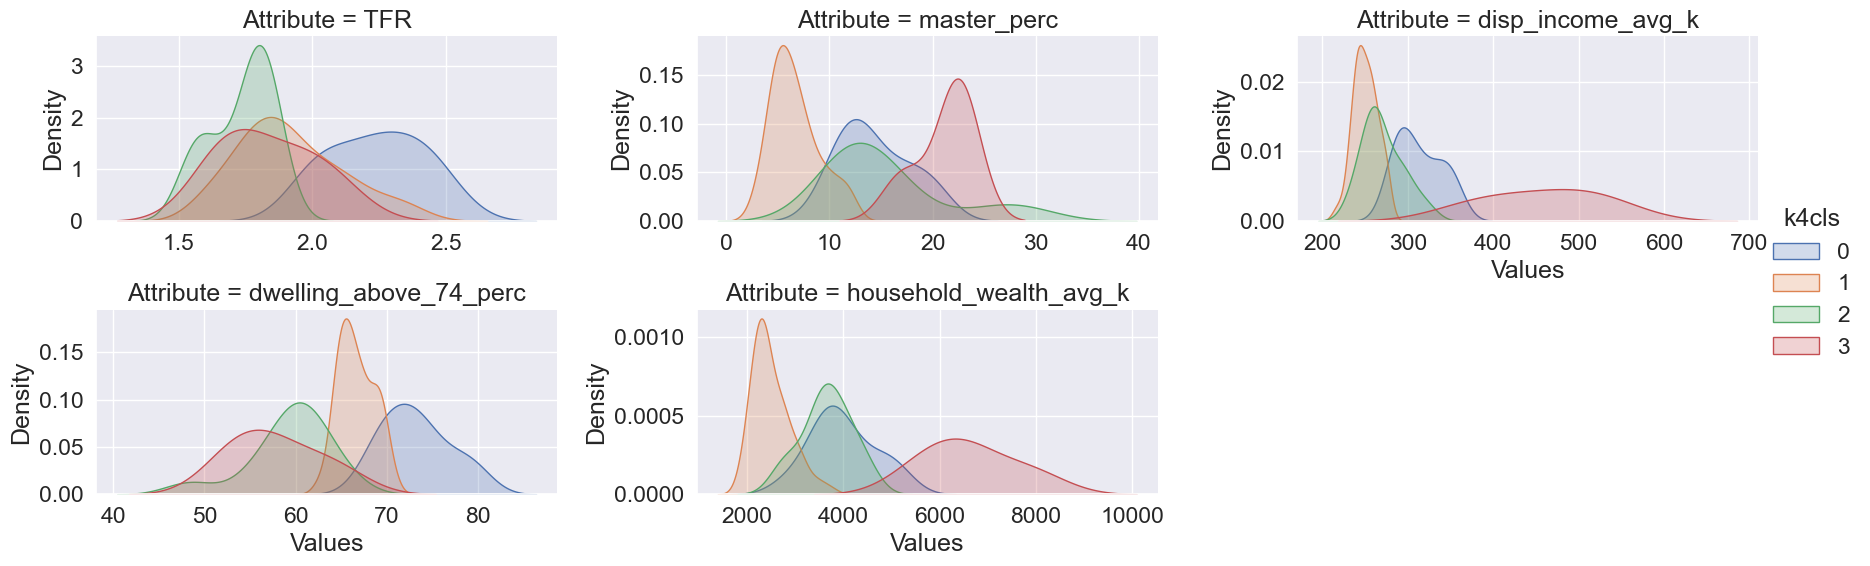

In [ ]:
# TODO: Anna: comment on these plots
# Index on cluster ID
tidy_db = gdf.set_index('k4cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cols]
# Stack column names into a column
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)



# Scale fonts 
sns.set(font_scale=1.5)
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='k4cls',
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)

facets.map(sns.kdeplot, "Values", fill=True,warn_singular=False).add_legend();

### Regionalization 

In [ ]:
# spatially-constrained version of the agglomerative algorithm

sagg13 = cluster.AgglomerativeClustering(n_clusters=8, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<93x93 sparse matrix of type '<class 'numpy.float64'>'
	with 1622 stored elements in Compressed Sparse Row format>,
                        n_clusters=8)

In [ ]:
# Run the clustering algorithm with scaled data
# TODO: how to scale data and why
sagg13cls = sagg13.fit(gdf[cluster_cols_scaled])

In [ ]:
# add to dataframe
gdf['sagg13cls'] = sagg13cls.labels_

In [ ]:
# Calculate the mean by group
sagg13_data = gdf.groupby('sagg13cls')[cols].mean()

sagg13_data.T

sagg13cls,0,1,2,3,4,5,6,7
TFR,2.253333,1.676667,1.790882,1.886667,1.855556,2.304,1.66,1.987241
master_perc,14.440000,25.646667,6.545000,20.830000,12.392222,12.036,16.68,6.464828
disp_income_avg_k,317.458889,319.006667,245.937647,485.413333,276.664444,277.122,262.50,251.032069
dwelling_above_74_perc,74.157778,52.716667,67.316176,59.386667,62.832222,67.074,55.29,65.421379
household_wealth_avg_k,4061.512222,4569.993333,2542.840294,6958.696667,3669.900000,3135.238,4283.29,2370.976552


In [ ]:
# custom colormap to ensure uniform colors between plots and maps
colors = ["#a6cee3",
"#1f78b4",
#"#b2df8a",
"#33a02c",
"#fb9a99",
"#e31a1c",
"#fdbf6f",
#"#ff7f00",
#"#cab2d6",
"#6a3d9a",
#"#ffff99",
"#b15928"]

keys = list(range(0,12))

color_dict={}

for k, c in zip(keys, colors):
    color_dict[k] = c

vals = gdf.sagg13cls.unique()
vals.sort()
cmap = mpl.colors.ListedColormap([color_dict[b] for b in vals])

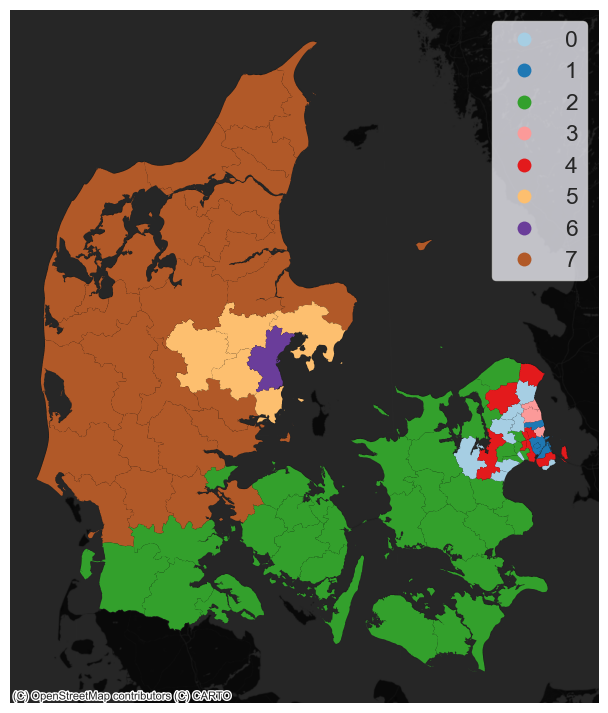

In [ ]:
# Plot clusters 
f, ax = plt.subplots(1, figsize=(9,9))

gdf.plot(
    column='sagg13cls', categorical=True, legend=True, linewidth=0, cmap=cmap, ax=ax
)
# Remove axis
ax.set_axis_off()

# Add basemap
cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels 
)
plt.savefig('KmeansclusterReg.png')

# Display the map
plt.show()

Draw the distributions of cluster members’ data:

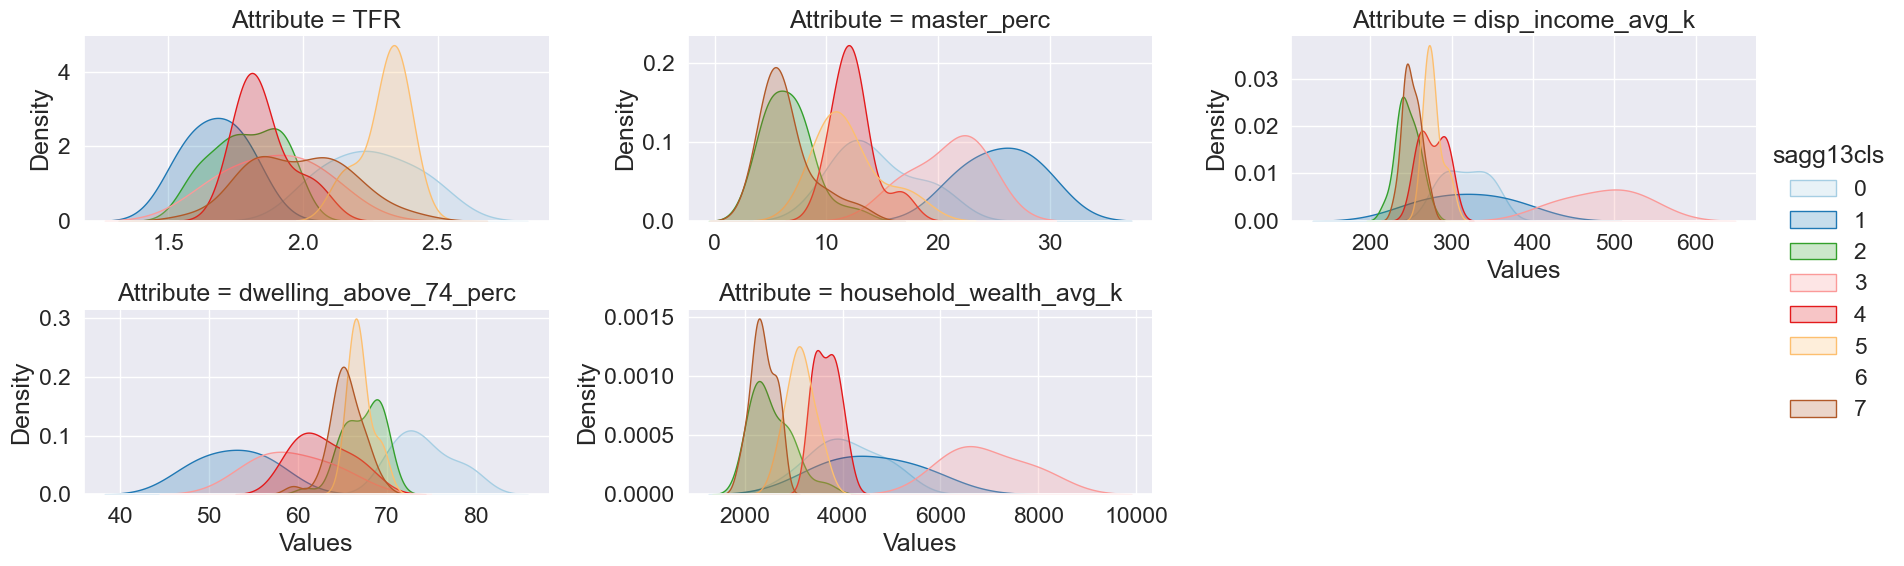

In [ ]:
# Index on cluster ID
tidy_db = gdf.set_index('sagg13cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cols]
# Stack column names into a column
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)

#sns.set(font_scale=1.5)

facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='sagg13cls',
    sharey=False,
    sharex=False,
    aspect=2,
    palette= colors, #'tab20',
    col_wrap=3,
)

facets.map(sns.kdeplot, "Values", fill=True, warn_singular=False).add_legend();

In [ ]:
# TODO: comparison: two plots in one 